# Deep Learning for Geo/Environmental sciences

<center><img src="../logo_2.png" alt="logo" width="500"/></center>

<em>*Created with ChapGPT</em>

## Lecture 10: Kolmogorov-Arnold Networks (KAN)


This tutorial is modified from Ziming Liu's tutorial on KANs: https://kindxiaoming.github.io/pykan/index.html. 

Read the KAN papers [here](https://doi.org/10.48550/arXiv.2404.19756).


## Kolmogorov-Arnold representation theorem

Kolmogorov-Arnold representation theorem states that if $f$ is a
multivariate continuous function on a bounded domain, then it can be
written as a finite composition of continuous functions of a single
variable and the binary operation of addition. More specifically, for a
smooth $f : [0,1]^n \to \mathbb{R}$,
$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$

where $\phi_{q,p}:[0,1]\to\mathbb{R}$ and
$\Phi_q:\mathbb{R}\to\mathbb{R}$. In a sense, they showed that the
only true multivariate function is addition, since every other function
can be written using univariate functions and sum. However, this 2-Layer
width-$(2n+1)$ Kolmogorov-Arnold representation may not be smooth
due to its limited expressive power. In KAN, its expressive power is augmented by
generalizing it to arbitrary depths and widths.


## Kolmogorov-Arnold Network (KAN)

<center><img src="_images/kan_plot.png" alt="logo" width="500"/></center>

The Kolmogorov-Arnold representation can be written in matrix form

$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$

where

${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$

We notice that both ${\bf \Phi}_{\rm in}$ and
${\bf \Phi}_{\rm out}$ are special cases of the following function
matrix :${\bf \Phi}$ (with :$n_{\rm in}$ inputs, and
$n_{\rm out}$ outputs), we call a Kolmogorov-Arnold layer:

${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$

${\bf \Phi}_{\rm in}$ corresponds to
$n_{\rm in}=n, n_{\rm out}=2n+1$, and ${\bf \Phi}_{\rm out}$
corresponds to $n_{\rm in}=2n+1, n_{\rm out}=1$.

After defining the layer, we can construct a Kolmogorov-Arnold network
simply by stacking layers! Let’s say we have $L$ layers, with the
$l^{\rm th}$ layer ${\bf \Phi}_l$ have shape
$(n_{l+1}, n_{l})$. Then the whole network is

$ {\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$

In constrast, a Multi-Layer Perceptron is interleaved by linear layers
${\bf W}_l$ and nonlinearities $\sigma$:

${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$

A KAN can be easily visualized. (1) A KAN is simply stack of KAN layers.
(2) Each KAN layer can be visualized as a fully-connected layer, with a
1D function placed on each edge. Let’s see an example below.

## Get started with KANs

## Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs’ ability to fit functions intialize model and create dataset

In [1]:
from kan import *
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
    
# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3, seed=1, device=device)
    
# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


Train KAN (grid=3)

In [2]:
model.fit(dataset, opt="LBFGS", steps=20);

| train_loss: 1.36e-02 | test_loss: 1.39e-02 | reg: 1.17e+01 | : 100%|█| 20/20 [00:01<00:00, 16.81it

saving model version 0.1


The loss plateaus. we want a more fine-grained KAN!

In [3]:
# initialize a more fine-grained KAN with G=10
model = model.refine(10)

saving model version 0.2



Train KAN (grid=10)

In [4]:
model.fit(dataset, opt="LBFGS", steps=20);

| train_loss: 6.49e-04 | test_loss: 6.82e-04 | reg: 1.17e+01 | : 100%|█| 20/20 [00:00<00:00, 23.87it

saving model version 0.3


The loss becomes lower. This is good! Now we can even iteratively making
grids finer.

In [5]:
grids = np.array([3,10,20,50,100])

train_losses = []
test_losses = []
steps = 200
k = 3
    
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k, seed=1, device=device)
    if i != 0:
        model = model.refine(grids[i])
        
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
        

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-02 | test_loss: 1.39e-02 | reg: 1.17e+01 | : 100%|█| 200/200 [00:02<00:00, 67.88


saving model version 0.1
saving model version 0.2


| train_loss: 4.65e-04 | test_loss: 4.80e-04 | reg: 1.17e+01 | : 100%|█| 200/200 [00:03<00:00, 58.55


saving model version 0.3
saving model version 0.4


| train_loss: 4.15e-05 | test_loss: 5.93e-05 | reg: 1.17e+01 | : 100%|█| 200/200 [00:04<00:00, 47.73


saving model version 0.5
saving model version 0.6


| train_loss: 1.66e-05 | test_loss: 4.09e-05 | reg: 1.17e+01 | : 100%|█| 200/200 [00:03<00:00, 53.92


saving model version 0.7
saving model version 0.8


| train_loss: 1.08e-05 | test_loss: 3.82e-05 | reg: 1.17e+01 | : 100%|█| 200/200 [00:06<00:00, 29.64

saving model version 0.9


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

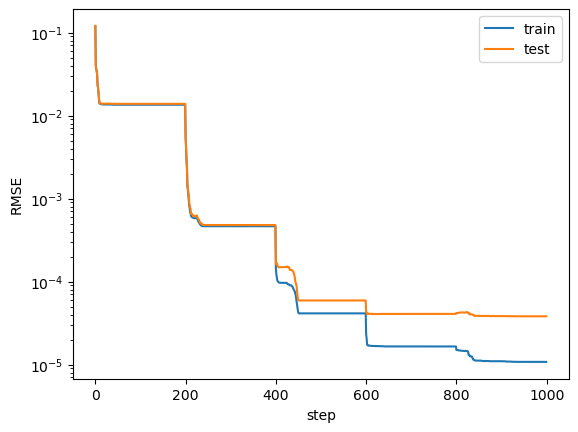

In [6]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws 

Text(0, 0.5, 'RMSE')

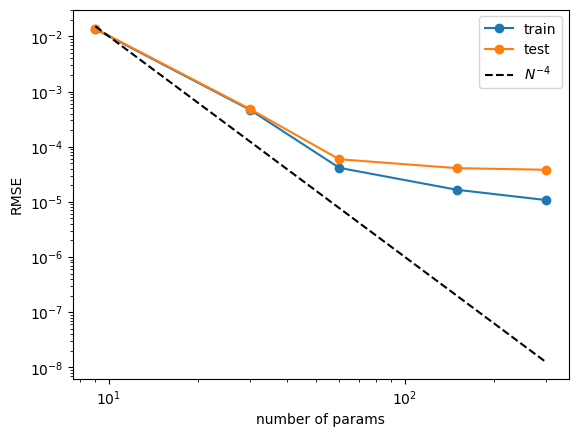

In [7]:
    n_params = 3 * grids
    train_vs_G = train_losses[(steps-1)::steps]
    test_vs_G = test_losses[(steps-1)::steps]
    plt.plot(n_params, train_vs_G, marker="o")
    plt.plot(n_params, test_vs_G, marker="o")
    plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(['train', 'test', r'$N^{-4}$'])
    plt.xlabel('number of params')
    plt.ylabel('RMSE')